In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import logging, sys, gc
import pandas as pd
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from frontiers_analysis import load_tissue

In [2]:
tissue="Bladder"
df = pd.read_csv(f"The_single_cell_transcriptome_as_a_component_system/MouseCellAtlas/mca/mainTable_{tissue}.csv", index_col=0)
M = df.sum(0)
f = df.divide(M,1).mean(1)
O = df.apply(lambda x: (x>0).sum(), 1)

In [3]:
from methods import mazzolini as sampling
from methods import mazzolini_broad as poissonian_sampling
from methods import mazzolini_nbinom as nbinom_sampling
from methods import mazzolini_gaus as gaus_sampling

In [4]:
M_tilde = 25000

# Create models

In [5]:
method_delta = sampling(M=M, f=f)
method_pois = poissonian_sampling(M=M, f=f, M_tilde=M_tilde)
#method_nbinom = nbinom_sampling(M=M, f=f, M_tilde=M_tilde)
method_gaus = gaus_sampling(M=M, f=f)

models = [method_delta, method_pois, method_gaus]
for method in models:
    print(method)
    method.run()

mazzolini
mazzolini_broad
mazzolini_gaus


## Zipf

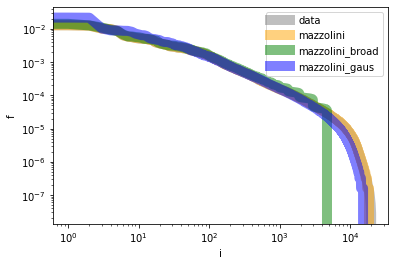

In [6]:
plt.plot(np.sort(f/f.sum())[::-1], lw=10, c="gray", alpha=0.5, label="data")
for model in models:
    plt.plot(model.get_f(), lw=10, alpha=0.5, label=model.name_, c=model.color_)

plt.xlabel("i")
plt.ylabel("f")

plt.xscale("log")
plt.yscale("log")

plt.legend()

## Heaps

mazzolini
mazzolini_broad
mazzolini_gaus


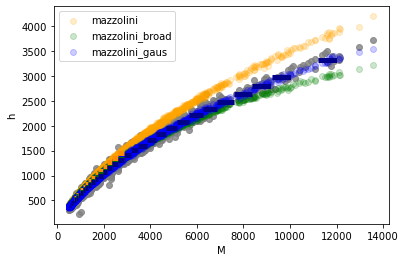

In [7]:
bins = np.logspace(np.log10(M.min()), np.log10(M.max()), 35)
#bins = np.linspace(M.min(), M.max(), 35)
    
plt.scatter(M, df.apply(lambda x: (x>0).sum(), 0), c="gray", alpha=0.8)
means, edges, _ = binned_statistic(M, model.get_h(), bins=bins)
var, edges, _ = binned_statistic(M, model.get_h(), statistic="std", bins=bins)
cnt, edges, _ = binned_statistic(M, model.get_h(), statistic="count", bins=bins)
var = var*var
mask = cnt > 10
means = means[mask]
var = var[mask]
l_edges = (edges[:-1])[mask]
r_edges = (edges[1:])[mask]
plt.hlines(means, l_edges, r_edges, lw=5, color="dark"+model.color_, ls="--")

for model in models:
    print(model.name_)
    means, edges, _ = binned_statistic(M, model.get_h(), bins=bins)
    var, edges, _ = binned_statistic(M, model.get_h(), statistic="std", bins=bins)
    cnt, edges, _ = binned_statistic(M, model.get_h(), statistic="count", bins=bins)
    var = var*var
    mask = cnt > 100
    means = means[mask]
    var = var[mask]
    l_edges = (edges[:-1])[mask]
    r_edges = (edges[1:])[mask]
    
    model.hmean = means
    model.hvar = var
    model.cnt = cnt

    plt.hlines(means, l_edges, r_edges, lw=5, color="dark"+model.color_, ls="--")

    plt.scatter(M, model.get_h(), alpha=0.2, c=model.color_, label=model.name_)

plt.xlabel("M")
plt.ylabel("h")

plt.legend()

### Fluctuations

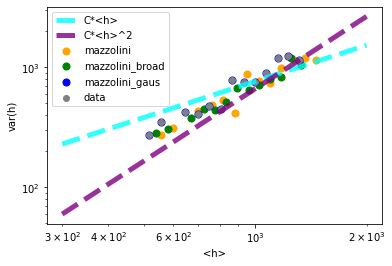

In [8]:
x = np.logspace(np.log10(300),np.log10(2000))

for model in models:
    plt.scatter(model.hmean, model.hvar, s=50, label=model.name_, c=model.color_)

plt.scatter(means, var, label="data", c="gray")
    
popt, pcov= curve_fit(lambda x, C: C*x, models[0].hmean, models[0].hvar)
plt.plot(x, popt[0]*x, lw=5, ls="--", c="cyan", alpha=0.8, label="C*<h>")

popt, pcov= curve_fit(lambda x, C: C*x*x, models[0].hmean, models[0].hvar)
plt.plot(x, popt[0]*x**2, lw=5, ls="--", c="purple", alpha=0.8, label ="C*<h>^2")
    
plt.xlabel("<h>")
plt.ylabel("var(h)")

plt.xscale("log")
plt.yscale("log")

plt.legend()

#plt.ylim(1e2,1e3)

## CV^2

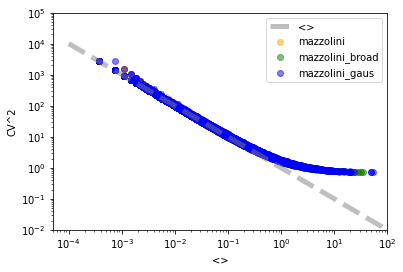

In [9]:
for model in models:
    means = np.mean(model.table,0)
    mean = means[means>0]
    var = np.var(model.table,0)
    cv2 = var[means>0]/mean/mean
    plt.scatter(mean,cv2, alpha=0.5, label=model.name_,c=model.color_)

x = np.linspace(1e-4,1e2,10)
plt.plot(x,1/x, alpha=0.5, label="<>",c="gray", ls="--", lw=5)

    
plt.xscale("log")
plt.yscale("log")

plt.xlabel("<>")
plt.ylabel("CV^2")

plt.ylim(1e-2,1e5)
plt.xlim(5e-5,1e2)


plt.legend()

## U

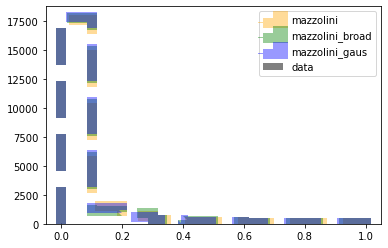

In [10]:
for model in models:
    plt.hist(model.get_O(), lw=10, ls="--", histtype="step", label=model.name_, color=model.color_, alpha=0.4)
    
plt.hist(O/O.sum(), color="gray", label="data")
plt.legend()

## Predicted occurrences

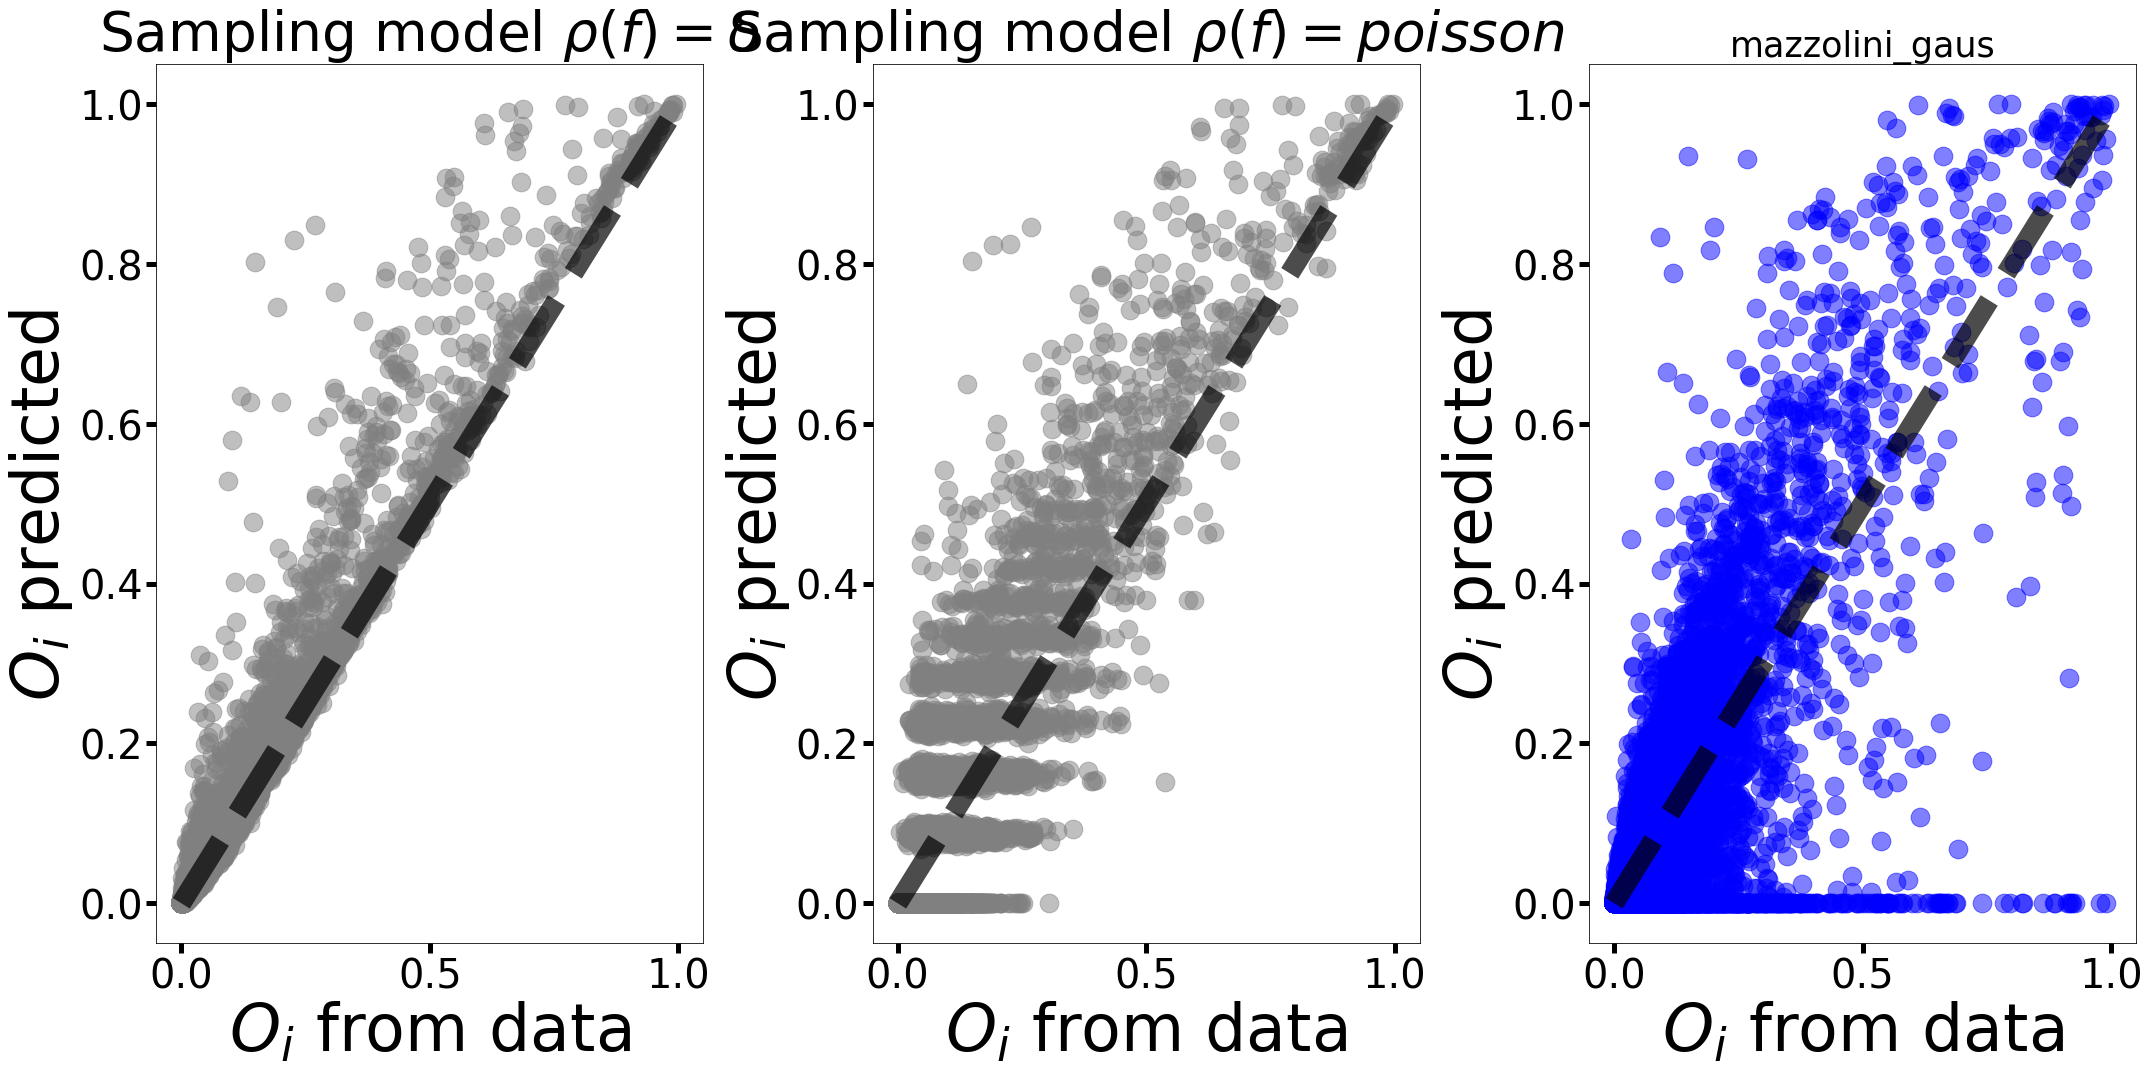

In [11]:
fig, axs = plt.subplots(1, len(models), figsize=(30, 15))

models[0].color_="gray"
models[1].color_="gray"
for model, ax in zip(models, axs):
    ax.scatter(O/df.shape[1], model.get_O(), label=model.name_, color=model.color_, alpha=0.5, s=350)
    ax.plot([0,1], [0,1], lw=20, alpha=0.7,ls="--", c="black")
    ax.set_title(model.name_, fontsize=35)
    
for ax in axs:
    ax.tick_params(labelsize=40, width=5, size=10)
    ax.set_xlabel("$O_i$ from data", fontsize=65)
    ax.set_ylabel("$O_i$ predicted", fontsize=65)
    
axs[0].set_title("Sampling model $\\rho(f)=\\delta$", fontsize=55)
axs[1].set_title("Sampling model $\\rho(f)={poisson}$", fontsize=55)

plt.tight_layout()
plt.show()
fig.savefig(f"Oreal_Opred_poissonModel_{tissue}.pdf")

# Sparsity

## Simulations
### Sampling

In [12]:
sparsities = []
for sample in range(10):
    model = sampling(M=M, f=f)
    model.run()
    E = (np.array(model.table)>0).sum()
    N = np.array(model.table).shape[0] * np.array(model.table).shape[1]
    sparsities.append(1-float(E)/N)

### Sampling from Poisson

In [13]:
#sparsities_pois_5 = []
#for sample in range(25):
#    model = poissonian_sampling(M=M, f=f, M_tilde=500000)
#    model.run()
#    E = (np.array(model.table)>0).sum().sum()
#    N = np.array(model.table).shape[0] * np.array(model.table).shape[1]
#    sparsities_pois_5.append(1-float(E)/N)

In [14]:
#sparsities_pois = []
#for sample in range(25):
#    model = poissonian_sampling(M=M, f=f, M_tilde=M_tilde)
#    model.run()
#    E = (np.array(model.table)>0).sum().sum()
#    N = np.array(model.table).shape[0] * np.array(model.table).shape[1]
#    sparsities_pois.append(1-float(E)/N)

### Sampling from gaus

In [16]:
sparsities_pois = []
for sample in range(25):
    model = gaus_sampling(M=M, f=f)
    model.run()
    E = (np.array(model.table)>0).sum().sum()
    N = np.array(model.table).shape[0] * np.array(model.table).shape[1]
    sparsities_pois.append(1-float(E)/N)

### Data

In [17]:
E = (df>0).sum().sum()
N = df.shape[0] * df.shape[1]
data_sparsity=[1-E/N]

## Plot

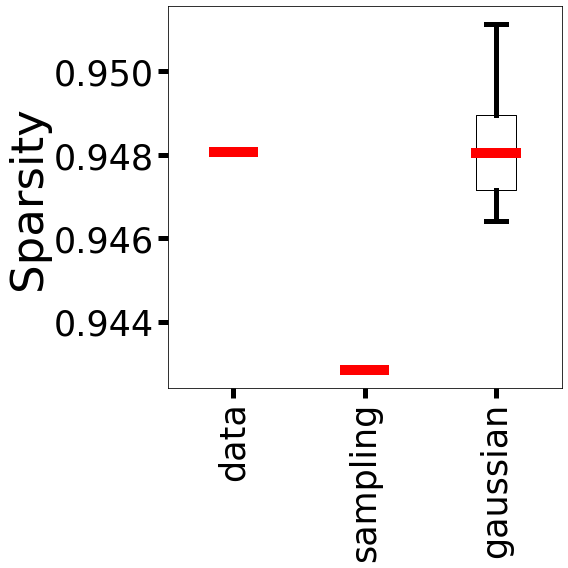

In [18]:
fig = plt.figure(figsize=(8,8))

#plt.boxplot([data_sparsity,sparsities,sparsities_pois_5, sparsities_pois], labels=["data", "sampling", "poissonian \n sampling \n (M=500000)", f"\n (M={M_tilde})"], medianprops={"lw":10, "color":"red"}, whiskerprops={"lw":5}, capprops={"lw":5})
plt.boxplot([data_sparsity,sparsities, sparsities_pois], labels=["data", "sampling", f"gaussian"], medianprops={"lw":10, "color":"red"}, whiskerprops={"lw":5}, capprops={"lw":5})



plt.ylabel("Sparsity", fontsize=45)
plt.xticks(rotation=90)
plt.tick_params(size=10, width=5, labelsize=35)
plt.tight_layout()
plt.show()
fig.savefig(f"Sparsity_box_{tissue}.pdf")